# **Convert Velodyne-data to Top-View Image** 
***

## Dataset
[KITTI 2011_09_26_drive_0005 dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php?type=city)  

refer to [KITTI Dataset Paper](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) for the details of data measurement environment

## Objective

Convert Velodyne data(model : HDL-64E) to Top-view image.
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kitti_foundation import Kitti, Kitti_util
%matplotlib inline

velo_path = './velodyne_points/data'

velo = Kitti_util(frame=89, velo_path=velo_path)
frame = velo.velo_file

print(frame.shape)

(123749, 3)


(-0.5, 400.5, 400.5, -0.5)

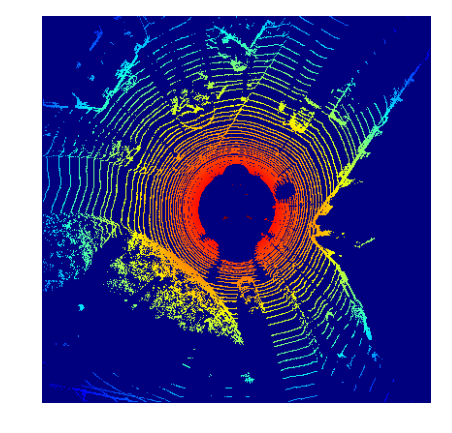

In [2]:
x_range, y_range, z_range, scale = (-20, 20), (-20, 20), (-2, 2), 10
topview_img = velo.velo_2_topview_frame(x_range=x_range, y_range=y_range, z_range=z_range)

# Plot result
plt.subplots(1,1, figsize = (5,5))
plt.imshow(topview_img)
plt.axis('off')

(-0.5, 200.5, 200.5, -0.5)

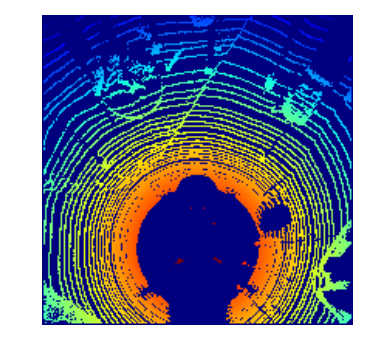

In [3]:
""" different range's result """

x_range, y_range, z_range, scale = (-5, 15), (-10, 10), (-2, 2), 10
topview_img = velo.velo_2_topview_frame(x_range=x_range, y_range=y_range, z_range=z_range)

# Plot result
plt.subplots(1,1, figsize = (4,4))
plt.imshow(topview_img)
plt.axis('off')

## Save Top-View Video

In [4]:
import cv2

# pre define range for image size
x_range, y_range, scale = (-20,20), (-20,20), 10
size = int((max(x_range)-min(x_range)) * scale), int((max(y_range)-min(y_range)) * scale)

velo2 = Kitti_util(frame='all', velo_path=velo_path)
topview = velo2.velo_2_topview(x_range=x_range, y_range=y_range, z_range=z_range, scale=scale)

""" save top view video """
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('topview.avi', fourcc, 25.0, size, False)

for frame in topview:
    vid.write(frame)

print('video saved')
vid.release()

video saved


## Display Top-View Video

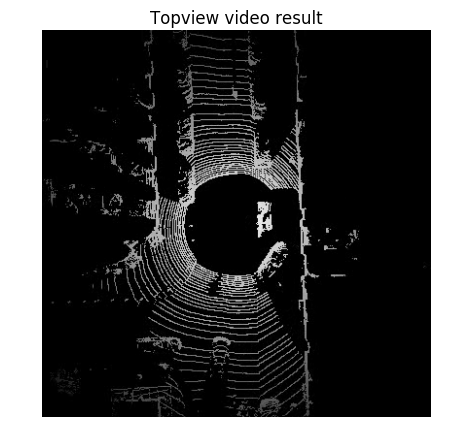

In [5]:
from IPython.display import clear_output

""" display video """
vid = cv2.VideoCapture("./topview.avi")

while(True):
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12,5))
    
    plt.title("Topview video result")
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()